Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Lucas Caetano Lopes Rodrigues"
COLLABORATORS = ""

---

# Lista 08 - Comparando Classificadores

# Exercício 01:

Analise o desempenho do kNN e de uma Regressão Logística Regularizada para **pelo menos um** dos conjuntos de dados abaixo:

* [Avaliação de carros](http://archive.ics.uci.edu/ml/datasets/Car+Evaluation)
* [Avaliação de vinhos](http://archive.ics.uci.edu/ml/datasets/Wine+Quality)
* [Resultados de partidas do jogo Dota](http://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results) (desafiador!)

Para a questão, faça as seguintes tarefas:

* Realize treino, validação e teste
* Compare as métricas no teste
* Reporte a precisão, revocação, F1 e a matriz de confusão

Como já estamos no fim da matéria, você pode agora fazer uso da biblioteca scikit-learn. Afinal, no dia a dia, não implementamos tudo do zero. Abaixo temos os imports que vocês precisam. Leiam a API da biblioteca para saber como fazer uso da mesma.

In [2]:
from scipy import stats as ss

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn.neighbors import KNeighborsClassifier

# Um fator importante é que o SKLearn não cria conjuntos de validação para você. Você tem algumas abordagens,
# uma é realizar um novo split no treino. Outra é fazer uso de classificadores com CV no fim.
# Tipo LogisticRegressionCV (ver na API). Por fim, você pode fazer uso da classe GridSearchCV.
# Leia a documentação da mesma.
from sklearn.model_selection import train_test_split

In [4]:
# O dataset escolhido foi o de avaliação de vinhos
df_red = pd.read_csv('./wineDataset/winequality-red.csv', sep=";")
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df_white = pd.read_csv('./wineDataset/winequality-white.csv', sep=";")
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
# Create a new column to tell whether the wine is red or white
# 0 for red, 1 for white
# Merge both dataframes
df_red['type'] = 0
df_white['type'] = 1
df = pd.concat([df_red, df_white])
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [7]:
# Separa em atributo que desejamos prever e o conjunto de dados
y = df['quality']
X = df.copy().drop('quality', axis=1)

# Separa em dataframe de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
# Converte a qualidade dos vinhos para 3 classes: 'Poor', 'Normal' e 'Excellent'
for i in range(11):
    if i <= 4:
        y_train = y_train.replace(i,'Poor')
        y_test = y_test.replace(i,'Poor')
    if i > 4 and i < 8:
        y_train = y_train.replace(i,'Normal')
        y_test = y_test.replace(i,'Normal')
    if i >= 8:
        y_train = y_train.replace(i,'Excellent')
        y_test = y_test.replace(i,'Excellent')

In [21]:
# Z-normalização dos dados de treino
scaler = StandardScaler()
Z_train = scaler.fit_transform(X_train)
Z_train = pd.DataFrame(Z_train, index=X_train.index, columns=X_train.columns)
Z_train['type'] = X_train['type']

# Z-normalização dos dados de teste
Z_test = scaler.fit_transform(X_test)
Z_test = pd.DataFrame(Z_test, index=X_test.index, columns=X_test.columns)
Z_test['type'] = X_test['type']

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
1391      -0.780496         -1.089833     1.035036       -0.852464  -0.758189   
590       -0.093289         -0.182163     1.240841        1.899893   0.083493   
2445      -0.475071         -0.000629     0.143210       -0.600339  -0.140955   
2403       1.204768         -0.061140     0.280414       -0.705391  -0.617908   
4831      -1.085921          0.241417    -0.405606       -0.915495   0.055437   
...             ...               ...          ...             ...        ...   
415        0.059423         -0.363697     0.280414        1.521706  -0.449572   
4856      -0.093289         -0.666254     0.486220        1.731810   0.055437   
1303       0.746630         -0.847788     0.280414        0.555230  -0.589852   
4821      -0.169646         -0.605742     1.035036       -0.873474  -0.365404   
2045       1.128412         -0.605742     0.211812       -1.020546  -0.393460   

      free sulfur dioxide  

In [10]:
# Implementação do modelo KNN
skf = StratifiedKFold(n_splits=5)
best = (0,0)
melhores = []

for train_index, val_index in skf.split(Z_train, y_train):
    for k in range(1,50):
        model = KNeighborsClassifier(n_neighbors = k)
        model.fit(Z_train.values[train_index],
                  y_train.values[train_index])
        
        # Validação do modelo
        y_val = y_train.values[val_index] # Valor real
        y_hat = model.predict(Z_train.values[val_index]) # Valor da predição
        precision = accuracy_score(y_val, y_hat)
        
        if precision > best[0]:
            best = (precision, k)
    
    melhores.append(best[1])

In [11]:
best_n = max(set(melhores), key=melhores.count)
model = KNeighborsClassifier(n_neighbors = best_n)
model.fit(Z_train, y_train)

print(classification_report(y_test, model.predict(Z_test)))

              precision    recall  f1-score   support

   Excellent       0.36      0.12      0.18        43
      Normal       0.92      0.99      0.96      1196
        Poor       0.40      0.03      0.06        61

    accuracy                           0.92      1300
   macro avg       0.56      0.38      0.40      1300
weighted avg       0.88      0.92      0.89      1300



In [12]:
# print(precision_score(y_test, model.predict(Z_test), average='micro'))
print(accuracy_score(y_test, model.predict(Z_test)))

0.9161538461538462


In [13]:
# Cria as labels para a confusion matrix
text_labels = ['Poor', 'Normal', 'Excellent']
index = np.arange(len(text_labels))
labels = pd.Series(text_labels, index=index)

([<matplotlib.axis.YTick at 0x7f0fb1ad7110>,
 <a list of 3 Text yticklabel objects>)

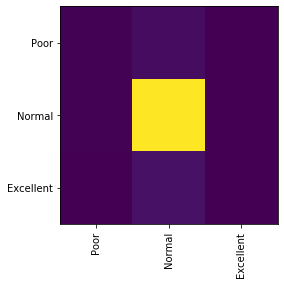

In [14]:
plt.imshow(confusion_matrix(y_test, model.predict(Z_test)))
plt.xticks(labels.index, labels, rotation=90)
plt.yticks(labels.index, labels)

In [15]:
from sklearn.linear_model import LogisticRegressionCV

logistic_model = LogisticRegressionCV(Cs=100,
                             penalty='l2',   #ridge
                             cv=5,           #5 folds internos
                             fit_intercept=False)
logistic_model.fit(Z_train, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
                     fit_intercept=False, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [16]:
print(classification_report(y_test, logistic_model.predict(Z_test)))
print(accuracy_score(y_test, logistic_model.predict(Z_test)))

              precision    recall  f1-score   support

   Excellent       0.00      0.00      0.00        43
      Normal       0.92      1.00      0.96      1196
        Poor       0.00      0.00      0.00        61

    accuracy                           0.92      1300
   macro avg       0.31      0.33      0.32      1300
weighted avg       0.85      0.92      0.88      1300

0.9184615384615384


/home/doc/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
def bootstrap_precision(X, y, trained_model, size=500):
    values = np.zeros(size)
    idx = np.arange(len(y))
    for i in range(size):
        sample = np.random.choice(idx, size=size, replace=True)
        values[i] = accuracy_score(y.values[sample], trained_model.predict(X.values[sample]))
    return values

def calcula_IC(data):
    # YOUR CODE HERE
    inferior = np.percentile(data, 2.5)
    superior = np.percentile(data, 97.5)
    return [inferior, superior]

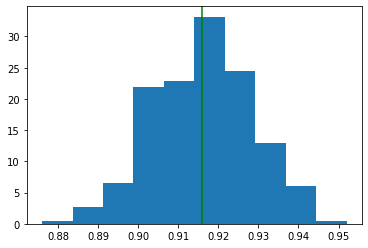

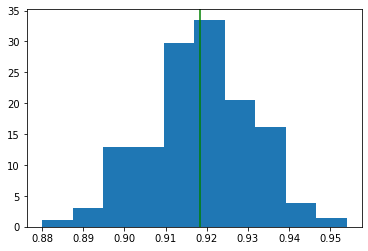

[0.892, 0.94]
[0.89295, 0.942]


In [18]:
samples_knn = bootstrap_precision(Z_test, y_test, model)
samples_logistic = bootstrap_precision(Z_test, y_test, logistic_model)

plt.hist(samples_knn, density=True)
plt.axvline(x=samples_knn.mean(), color='green')
plt.show()

plt.hist(samples_logistic, density=True)
plt.axvline(x=samples_logistic.mean(), color='green')
plt.show()

print(calcula_IC(samples_knn))
print(calcula_IC(samples_logistic))

Explique e discuta sobre os resultados encontrados no campo abaixo.

Surpreendentemente, ambos os modelos tiveram resultados muito similares. Embora as distribuições para os testes de bootstrap se mostrem ligeiramente diferentes, assim como os resultados de `accuracy_score` para os dados de teste, o intervalo de confiança e a média são os mesmos, mostrando que ambos os modelos de KNN e regressão logística apresentam o mesmo resultado prático para o dataset avaliado.

Talvez esse cenário seja causado porque esse dataset tem uma distribuição degenerada para o atributo "qualidade" - com muitos registros cuja qualidade é classificada como "Normal" (entre 5 e 7) e poucos registros cuja qualidade é classificada como "Poor" (entre 1 e 4) e "Excellent" (acima de 8).